In [1]:
from food.psql import *
from food.paths import *
from food.tools import *
import pandas as pd
from food.search_glovo import *
from tqdm import tqdm
from food.search import series2tensor,cos

In [10]:
foods = pd.read_sql("""select f.* from food.foods f
                       left join food.foods_prompted_images_new i on (f.id = i.food_id)
                       where i.food_id is null""",engine).set_index('id')
len(foods)
                       


215

In [11]:
foods

,description,category,energy,protein,carb,fat,clip
id,,,,,,,
1097873,"Milk, dry, not reconstituted, NS as to fat con...",Not included in a food category,362.0,36.16,51.98,0.77,"[-0.01535099, 0.008864938, -0.006253339, 0.041..."
1097876,"Milk, dry, not reconstituted, fat free (skim)",Not included in a food category,362.0,36.16,51.98,0.77,"[0.014727862, 0.021453906, -0.0035733033, 0.04..."
1098090,Cheese souffle,Eggs and omelets,204.0,9.45,6.29,15.70,"[0.024138886, -0.0077868854, -0.0049513155, 0...."
1098149,Alfredo sauce with seafood,"Dips, gravies, other sauces",144.0,6.11,1.76,12.56,"[0.0024527004, 0.02530213, 0.002376126, -0.004..."
1098257,"Pork chop, smoked or cured, cooked, NS as to f...",Cold cuts and cured meats,280.0,20.43,0.00,21.35,"[0.004015844, 0.019401532, 0.0061916346, -0.03..."
...,...,...,...,...,...,...,...
1104591,Sauce as ingredient in hamburgers,Not included in a food category,271.0,1.34,17.14,22.85,"[0.0025118093, 0.023615584, 0.008657991, -0.02..."
1101179,Baklava,Cakes and pies,413.0,5.62,38.58,27.23,"[-0.0044217273, -0.020382235, 0.011087513, 0.0..."
1101309,Rice paper,"Crackers, excludes saltines",329.0,5.07,72.54,1.21,"[0.082201175, -0.010305371, -0.007898131, 0.01..."


In [7]:
food_categories = pd.read_sql("select * from food.food_categories",engine)
food_categories_t = series2tensor(food_categories['clip'])

In [8]:
pd_iter = foods[['description','category']].iterrows()

In [9]:
for inp in tqdm(pd_iter, desc="clip food inference", total=len(foods) // 1):  
    food_categories_ = food_categories.copy()
    food, category = inp[1].tolist()
    food_id = inp[0]
    matching_photos_df = search_by_text(food,topk=20,params={},prompt = None,prompt_factor=3,collection_name=project_name,return_clip = True)
    matching_photos_df = matching_photos_df[matching_photos_df['accuracy']>0.22]
    matching_photos_df_iter = matching_photos_df[['clip']].iterrows()
    keep =[]
    for matching_photo in matching_photos_df_iter:
        matching_clip = series2tensor(matching_photo[1])
        food_categories_['score']=cos(matching_clip,food_categories_t)
        inferenced_cats = food_categories_[food_categories_['score']>0.2].sort_values('score',ascending = False)['category'].tolist()
        if category in inferenced_cats:keep.append(matching_photo[0])
    matching_photos_df = matching_photos_df.loc[keep]
    matching_photos_df['food_id'] = food_id
    matching_photos_df = matching_photos_df[['food_id','country_code','store_name','product_name','path','accuracy','clip']]
    matching_photos_df.to_sql('foods_prompted_images_new',schema='food',con = engine,index =False,if_exists= 'append')








clip food inference: 100%|██████████| 215/215 [00:24<00:00,  8.94it/s]


In [ ]:
1

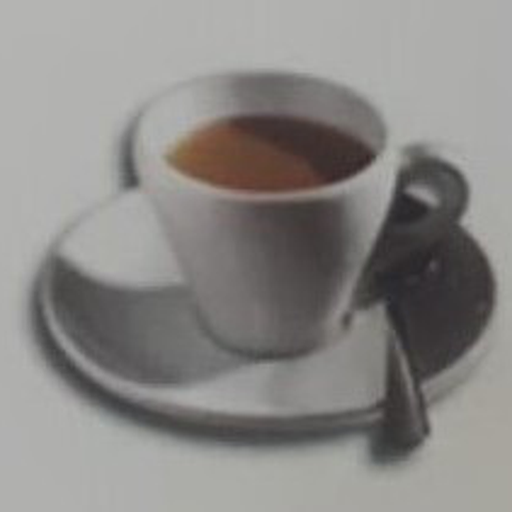

In [45]:
get_image_from_url(matching_photos_df['url'].sample(1).iloc[0])

In [9]:
inferenced_cats

['Coffee', 'Yogurt, Greek']

In [10]:
keep

[]

In [18]:
matching_photos_df

,country_code,city_code,store_name,product_name,collection_section,product_description,path,clip,accuracy,url,food_id
2,PL,WAW,Keto City,KETO Młoda Kapusta,Dania główne,"Kapusta, kiełbasa, koper, dymka 1017,5kcal t...",XMJCLQB_0027883_1814383176.png,"[0.04523388, 0.018702447, 0.00091965904, -0.04...",0.307347,http://glovo.away.guru/photos_resized/XMJCLQB_...,1099619
3,RS,BEG,Restoran Tošin Bunar - Džakarta,Svadbarski kupus,KUVANA JELA,None,YNZQPLX_0032916_1486985484.png,"[0.04593106, 0.025783543, -0.028795213, -0.031...",0.306530,http://glovo.away.guru/photos_resized/YNZQPLX_...,1099619
8,KG,BSK,Cibo Sano / Чибо Сано,"Салат ""Оливье""",САЛАТЫ,"Ветчина говяжья, картофель отварной, морковь, ...",KTBRPSX_0005622_1430809726.png,"[0.07513195, 0.09609195, 0.041814387, -0.03381...",0.300666,http://glovo.away.guru/photos_resized/KTBRPSX_...,1099619
10,RO,BUC,mEaters,Varza calita,INSOTITOARE DE CARNURI,250g,NYSZDZV_0142859_2195959850.png,"[0.022673449, 0.03656794, -0.018089892, -0.020...",0.297093,http://glovo.away.guru/photos_resized/NYSZDZV_...,1099619
14,RO,SCV,Ceaunul Razesului,"Varza calita cu ciolan afumat, mamaliguta si a...",SPECIALITATI TRADITIONALE,"Varza murata, morcov, ceapa, sos de rosii, cim...",NWGBDJC_0001419_1483928003.png,"[0.052310865, 0.017492132, -0.024858298, -0.01...",0.293524,http://glovo.away.guru/photos_resized/NWGBDJC_...,1099619
16,RS,BEG,Taze Toplo,Podvarak sa prilogom,Kuvana jela i a la kart ponuda,500 - 550g porcija,YNZQPLX_0078492_2047529596.png,"[0.056192297, 0.050830603, -0.0325037, -0.0054...",0.292589,http://glovo.away.guru/photos_resized/YNZQPLX_...,1099619
19,KZ,ATR,Tengri Food,"салат ""Тоско"" (440 гр.)",САЛАТЫ,None,GBJZFRS_0003110_1604842627.png,"[0.082602344, 0.043721933, -0.02791057, 0.0160...",0.291492,http://glovo.away.guru/photos_resized/GBJZFRS_...,1099619


In [34]:
keep

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [35]:
inferenced_cats

['Flavored milk, lowfat',
 'Milk, lowfat',
 'Flavored milk, reduced fat',
 'Flavored milk, nonfat',
 'Milk, reduced fat',
 'Milk, nonfat',
 'Flavored milk, whole',
 'Milk, whole',
 'Milk shakes and other dairy drinks',
 'Formula, ready-to-feed',
 'Yogurt, regular',
 'Ready-to-eat cereal, lower sugar (=<21.2g/100g)',
 'Cream and cream substitutes',
 'Milk substitutes',
 'Baby food: yogurt',
 'Human milk',
 'Baby food: meat and dinners',
 'Baby juice',
 'Diet soft drinks',
 'Formula, prepared from concentrate',
 'Processed soy products',
 'Nutritional beverages',
 'Baby food: cereals',
 'Baby food: snacks and sweets',
 'Ready-to-eat cereal, higher sugar (>21.2g/100g)']

In [22]:
category

'Milk, nonfat'

In [23]:
category in inferenced_cats

True

In [74]:
food, category

('Milk, lactose free, whole', 'Milk, whole')

In [75]:
matching_photos_df

,country_code,city_code,store_name,product_name,collection_section,product_description,path,clip,accuracy,url
0,GT,AAZ,AS_018,Lala Leche Entera 1L,Leche,None,BBYJKXD_0005144_1150329017.png,"[0.008715597, 0.05416621, -0.012822622, 0.0644...",0.273046,http://glovo.away.guru/photos_resized/BBYJKXD_...
1,CL,VIN,Tottus,Leche Semidescremada Sin Lactosa Soprole 1 Lt ...,Leche Especial,None,DYBHWCJ_0000738_22053061.png,"[0.0379849, 0.08915244, 0.02751343, 0.03320773...",0.272717,http://glovo.away.guru/photos_resized/DYBHWCJ_...
2,PE,LIM,AS_059,Leche Uht Delta Entera 0.946 Lt,Leches Liquidas,None,VJTTJQD_0155628_1294464558.png,"[0.011755043, 0.0666493, 0.0020294723, 0.01441...",0.268783,http://glovo.away.guru/photos_resized/VJTTJQD_...
3,KE,NBO,Olare Wine Naivas categorised,Daima Uht Whole Milk Pouch 500 Ml,Milk,None,ZLCMNZH_0019792_1180445130.png,"[0.011520941, 0.031641852, 0.011195459, 0.0625...",0.267619,http://glovo.away.guru/photos_resized/ZLCMNZH_...
4,PE,LIM,AS_203,Nevada Deslactosada Lacteos 1 Lt,Leches,None,VJTTJQD_0054245_1150412969.png,"[0.042399332, 0.052361503, 0.013400423, 0.0463...",0.266006,http://glovo.away.guru/photos_resized/VJTTJQD_...
5,PA,CRA,ZAZ,Nevada Free 946Ml,Leche,None,NMGQHQX_0004659_1254422117.png,"[0.03175901, 0.051566217, 0.01842916, 0.046544...",0.265861,http://glovo.away.guru/photos_resized/NMGQHQX_...
6,PE,LIM,AS_051,Semidescremada Trebolac Uhttetra 1000Ml,Leche Líquida,None,VJTTJQD_0131660_1274519335.png,"[0.029412502, 0.046370283, 0.021041306, 0.0451...",0.265748,http://glovo.away.guru/photos_resized/VJTTJQD_...
7,AR,BUE,AS_192,Nevada Deslactosada Lacteos 1 Lt,Leches,None,CBNGZLF_0019977_1122798882.png,"[0.04179886, 0.052369952, 0.0140798595, 0.0474...",0.265488,http://glovo.away.guru/photos_resized/CBNGZLF_...
8,KE,NBO,AS_144,Brookside Disney Tca Milk 200Ml,Milk,None,ZLCMNZH_0111246_1627981569.png,"[0.044229966, 0.015671032, 0.007973057, 0.1326...",0.265426,http://glovo.away.guru/photos_resized/ZLCMNZH_...
9,ES,BCN,AS_173,Nevada Deslactosada Lacteos 1 Lt,Leches,None,BFDKZRG_0066811_1147088002.png,"[0.041791428, 0.05342573, 0.01322516, 0.048709...",0.264914,http://glovo.away.guru/photos_resized/BFDKZRG_...


In [29]:
df_t = series2tensor(df['clip'])

In [35]:
food_categories_t.shape

torch.Size([167, 768])

In [34]:
df_t.shape

torch.Size([20, 768])

In [56]:
df_t

tensor([[ 0.0380,  0.0892,  0.0275,  ...,  0.0205,  0.0130, -0.0003],
        [ 0.0495,  0.0807, -0.0112,  ...,  0.0222, -0.0128,  0.0238],
        [ 0.0706,  0.1139,  0.0106,  ...,  0.0243,  0.0144,  0.0039],
        ...,
        [ 0.0236,  0.0652, -0.0570,  ...,  0.0073,  0.0129, -0.0161],
        [ 0.0111,  0.0557, -0.0205,  ..., -0.0170,  0.0119, -0.0009],
        [ 0.0419,  0.1044, -0.0003,  ..., -0.0043,  0.0005,  0.0113]],
       dtype=torch.float64)

In [3]:
pd.read_sql('select * from glovo.clips limit 5',engine)

,id,clip
0,90684,"[0.01659354, 0.013505786, 0.02141453, -0.00664..."
1,737587,"[0.01139133, 0.013935307, 0.00682624, -0.00831..."
2,586880,"[0.024800692, -0.005677419, 0.009203069, -0.01..."
3,1137723,"[-0.018988553, 0.018730529, -0.04642961, 0.008..."
4,1323295,"[0.011928837, 0.032037217, 0.005245935, 0.0041..."
